In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.set_option('display.precision',10)
from tensorflow.keras import layers
##from tf.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# load dataset
df = pd.read_csv("dataset.csv")
df.head()
an = pd.read_csv("anniv.csv")
an.head()

ranking_idol  an1_top100  an1_top1000  an2_top100  an2_top1000  \
0      amami haruka     1156358       123212     1377497       365723   
1  kisaragi chihaya     1193282       157201     2492920       483480   
2        hoshi miki     1363781       164464     2192241       512193   
3   hagiwara yukiho      963271       100014     1843446       311513   
4   takatsuki yayoi      919576        86908     1666666       277722   

   an3_top100  an3_top1000  
0     2421905       526601  
1     2500466       636097  
2     3133010       751410  
3     2484539       436297  
4     2476195       354774

In [4]:
df.head()

ranking_idol   appearing_idol_1 appearing_idol_2 appearing_idol_3  \
0   kitazawa shiho     nonohara akane  hakozaki serika   mogami shizuka   
1  takatsuki yayoi       nakatani iku      yabuki kana     ogami tamaki   
2     nanao yuriko      makabe mizuki   mochizuki anna    ibuki tsubasa   
3   mogami shizuka  shiraishi tsumugi   kitazawa shiho            julia   
4       momose rio    shimabara elena    shijou takane  shinomiya karen   

  appearing_idol_4 event_type   start  duration  t1_cutoff  t2_cutoff  \
0   kitakami reika    theater  201708         9     151347      67477   
1              NaN    theater  201709        11     103398      54179   
2     kasuga mirai    theater  201709        11     135591      56477   
3    tokoro megumi       tour  201710        11     371237     137697   
4       handa roco    theater  201711         9      88037      44374   

   t3_cutoff  
0      45991  
1      43411  
2      41397  
3      83660  
4      36350

Get average values for each tier of anniv (Cleanest data)

In [5]:
df = df[df.event_type != "twin"]
df.head()

ranking_idol   appearing_idol_1 appearing_idol_2 appearing_idol_3  \
0   kitazawa shiho     nonohara akane  hakozaki serika   mogami shizuka   
1  takatsuki yayoi       nakatani iku      yabuki kana     ogami tamaki   
2     nanao yuriko      makabe mizuki   mochizuki anna    ibuki tsubasa   
3   mogami shizuka  shiraishi tsumugi   kitazawa shiho            julia   
4       momose rio    shimabara elena    shijou takane  shinomiya karen   

  appearing_idol_4 event_type   start  duration  t1_cutoff  t2_cutoff  \
0   kitakami reika    theater  201708         9     151347      67477   
1              NaN    theater  201709        11     103398      54179   
2     kasuga mirai    theater  201709        11     135591      56477   
3    tokoro megumi       tour  201710        11     371237     137697   
4       handa roco    theater  201711         9      88037      44374   

   t3_cutoff  
0      45991  
1      43411  
2      41397  
3      83660  
4      36350

In [6]:
ranking_arr = pd.unique(df.ranking_idol)
ranking = pd.DataFrame(data=ranking_arr, columns=['idol'])
ranking['avg_score_norm'] = 0
ranking.shape

(52, 2)

In [7]:
ranking.head()

idol  avg_score_norm
0   kitazawa shiho               0
1  takatsuki yayoi               0
2     nanao yuriko               0
3   mogami shizuka               0
4       momose rio               0

In [8]:
# for i, row in df.iterrows():
#     idol = row['ranking_idol']
#     score_t1 = 0
#     score_t2 = 0
#     if(row['event_type'] == 'anniv'):
#         score_t1 = row['t1_cutoff']/t1_mean
#         score_t2 = row['t2_cutoff']/t2_mean      
#         for j, row2 in ranking.iterrows():
#             if (row2['idol'] == idol):
#                 avg = row2['avg_score_norm']
#                 ranking.loc[j, 'avg_score_norm'] = (avg + score_t1 + score_t2)/3


        

In [9]:
cols = list(an.columns)
cols.remove('ranking_idol')
for col in cols:
    an[col] = ((an[col] - an[col].mean())/an[col].std())

In [10]:
an.head()

ranking_idol    an1_top100   an1_top1000    an2_top100   an2_top1000  \
0      amami haruka  0.6063790144  0.5208657280 -0.9175531367  0.2211468933   
1  kisaragi chihaya  0.7130068121  1.2866924729  1.4279711561  1.1246708970   
2        hoshi miki  1.2053676854  1.4503395249  0.7956999022  1.3449795387   
3   hagiwara yukiho  0.0487893280 -0.0018224603  0.0622497710 -0.1947947173   
4   takatsuki yayoi -0.0773915197 -0.2971216841 -0.3094852430 -0.4540657552   

     an3_top100   an3_top1000  
0  0.0326537498  0.3182228395  
1  0.1479849208  0.8979130064  
2  1.0765886838  1.5083993458  
3  0.1246033503 -0.1598616644  
4  0.1123539735 -0.5914580832

In [11]:
an['avg_score'] = an[cols].mean(axis=1)
an.head()

ranking_idol    an1_top100   an1_top1000    an2_top100   an2_top1000  \
0      amami haruka  0.6063790144  0.5208657280 -0.9175531367  0.2211468933   
1  kisaragi chihaya  0.7130068121  1.2866924729  1.4279711561  1.1246708970   
2        hoshi miki  1.2053676854  1.4503395249  0.7956999022  1.3449795387   
3   hagiwara yukiho  0.0487893280 -0.0018224603  0.0622497710 -0.1947947173   
4   takatsuki yayoi -0.0773915197 -0.2971216841 -0.3094852430 -0.4540657552   

     an3_top100   an3_top1000     avg_score  
0  0.0326537498  0.3182228395  0.1302858480  
1  0.1479849208  0.8979130064  0.9330398776  
2  1.0765886838  1.5083993458  1.2302291135  
3  0.1246033503 -0.1598616644 -0.0201393988  
4  0.1123539735 -0.5914580832 -0.2695280520

In [12]:
rk = pd.DataFrame(ranking)
rk= rk.merge(an, left_on='idol', right_on='ranking_idol')
rk = rk[['idol','avg_score']]
rk.head()

idol     avg_score
0   kitazawa shiho  1.0632513717
1  takatsuki yayoi -0.2695280520
2     nanao yuriko  1.7725417519
3   mogami shizuka  0.6158546162
4       momose rio -0.2216665865

In [13]:
rk.sort_values(by=['avg_score'], inplace=True)
rk.reset_index(drop=True, inplace=True)

In [14]:
rk

idol     avg_score
0          futami ami -1.9214164457
1       maihama ayumu -1.5984191976
2         futami mami -1.5487838460
3       fukuda noriko -1.5286677616
4    kinoshita hinata -1.2147259204
5     akizuki ritsuko -1.1678304860
6        ogami tamaki -1.1090168019
7         miura azusa -1.0439240332
8      nonohara akane -0.9831218882
9        nakatani iku -0.8923319540
10      matsuda arisa -0.8315327564
11    nikaido chizuru -0.8190878906
12    shinomiya karen -0.6786504500
13    shimabara elena -0.4339780642
14     toyokawa fuuka -0.4028474603
15        yabuki kana -0.3983487268
16         handa roco -0.3653572310
17      satake minako -0.3484348760
18   nagayoshi subaru -0.3250993844
19      emily stewart -0.3112603607
20     kikuchi makoto -0.3074480179
21    takatsuki yayoi -0.2695280520
22    takayama sayoko -0.2623198010
23         momose rio -0.2216665865
24     kitakami reika -0.1878185650
25       yokoyama nao -0.1538561937
26  tenkubashi tomoka -0.1308151554
27      ganaha hibiki -0.0205986095
28    hagiwara yukiho -0.0201393988
29         miyao miya  0.0718829647
30      shijou takane  0.0892871186
31       kasuga mirai  0.1174481738
32       amami haruka  0.1302858480
33        minase iori  0.1656462875
34      ibuki tsubasa  0.1657573181
35              julia  0.2159340150
36   tokugawa matsuri  0.4130233619
37        kousaka umi  0.5424630683
38     mogami shizuka  0.6158546162
39        baba konomi  0.7856785705
40      tokoro megumi  0.9156940091
41   kisaragi chihaya  0.9330398776
42   sakuramori kaori  0.9467879669
43     kitazawa shiho  1.0632513717
44      makabe mizuki  1.1159193945
45         hoshi miki  1.2302291135
46    hakozaki serika  1.2778319508
47  shiraishi tsumugi  1.4726833043
48        suou momoko  1.4974910652
49       nanao yuriko  1.7725417519
50      tanaka kotoha  1.7831176621
51     mochizuki anna  2.1751771046

In [15]:
df_clean = df.copy()

In [16]:
for i, row in df_clean.iterrows():
    #Idol 1 (main)
    idol=row['ranking_idol']
    main=row['ranking_idol']
    for j, row2 in rk.iterrows():
            if (row2['idol'] == idol):
                df_clean.loc[i, 'ranking_idol'] = row2['avg_score']
                main = row2['avg_score']
                
    #Idol 2 (sub)
    idol=row['appearing_idol_1']
    sub=row['appearing_idol_1']
    for j, row2 in rk.iterrows():
            if (row2['idol'] == idol):
                df_clean.loc[i, 'appearing_idol_1'] = row2['avg_score']
                
    #Idol 3
    idol=row['appearing_idol_2']
    df_clean.loc[i, 'appearing_idol_2'] = 0
    for j, row2 in rk.iterrows():
            if (row2['idol'] == idol):
                df_clean.loc[i, 'appearing_idol_2'] = row2['avg_score']
    
    #Idol 4
    idol=row['appearing_idol_3']
    df_clean.loc[i, 'appearing_idol_3'] = 0
    for j, row2 in rk.iterrows():
            if (row2['idol'] == idol):
                df_clean.loc[i, 'appearing_idol_3'] = row2['avg_score']
                
    #Idol 5
    idol=row['appearing_idol_4']
    df_clean.loc[i, 'appearing_idol_4'] = 0
    for j, row2 in rk.iterrows():
            if (row2['idol'] == idol):
                df_clean.loc[i, 'appearing_idol_4'] = row2['avg_score']
    

In [17]:
df_clean.head(10)

ranking_idol appearing_idol_1 appearing_idol_2 appearing_idol_3  \
0  1.0632513717    -0.9831218882     1.2778319508     0.6158546162   
1  -0.269528052     -0.892331954    -0.3983487268    -1.1090168019   
2  1.7725417519     1.1159193945     2.1751771046     0.1657573181   
3  0.6158546162     1.4726833043     1.0632513717      0.215934015   
4 -0.2216665865    -0.4339780642     0.0892871186      -0.67865045   
5  0.1657573181     0.9467879669     2.1751771046     1.2778319508   
6  -1.548783846     -0.348434876     0.7856785705     -0.892331954   
7  0.1174481738     0.4130233619     1.7725417519    -0.3112603607   
8 -0.8315327564     1.4974910652      0.130285848    -0.1538561937   
9 -0.8190878906    -0.1308151554    -0.2216665865     0.9156940091   

  appearing_idol_4 event_type   start  duration  t1_cutoff  t2_cutoff  \
0     -0.187818565    theater  201708         9     151347      67477   
1                0    theater  201709        11     103398      54179   
2     0.1174481738    theater  201709        11     135591      56477   
3     0.9156940091       tour  201710        11     371237     137697   
4     -0.365357231    theater  201711         9      88037      44374   
5     -0.187818565       tour  201711         9     207072      72108   
6    -1.2147259204    theater  201712         8      87912      41800   
7    -0.3983487268       tour  201712         9     284240      79122   
8    -1.5286677616    theater  201801         7     123222      54202   
9                0       tour  201801         7     161014      68412   

   t3_cutoff  
0      45991  
1      43411  
2      41397  
3      83660  
4      36350  
5      51044  
6      33099  
7      55386  
8      40630  
9      52578

In [18]:
for i, row in df_clean.iterrows():
    main=row['ranking_idol']
    sub=row['appearing_idol_1']
    ap2=row['appearing_idol_2']
    ap3=row['appearing_idol_3']
                
    #Idol 3
    idol=row['appearing_idol_2']
    if idol==0:
        df_clean.loc[i, 'appearing_idol_2'] = (main+sub)/2

    
    #Idol 4
    idol=row['appearing_idol_3']
    if idol==0:
        df_clean.loc[i, 'appearing_idol_3'] = (main+sub+ap2)/3

                
    #Idol 5
    idol=row['appearing_idol_4']
    if idol==0:
        df_clean.loc[i, 'appearing_idol_4'] = (main+sub+ap2+ap3)/4

    

In [19]:
df_clean.head(10)

ranking_idol appearing_idol_1 appearing_idol_2 appearing_idol_3  \
0  1.0632513717    -0.9831218882     1.2778319508     0.6158546162   
1  -0.269528052     -0.892331954    -0.3983487268    -1.1090168019   
2  1.7725417519     1.1159193945     2.1751771046     0.1657573181   
3  0.6158546162     1.4726833043     1.0632513717      0.215934015   
4 -0.2216665865    -0.4339780642     0.0892871186      -0.67865045   
5  0.1657573181     0.9467879669     2.1751771046     1.2778319508   
6  -1.548783846     -0.348434876     0.7856785705     -0.892331954   
7  0.1174481738     0.4130233619     1.7725417519    -0.3112603607   
8 -0.8315327564     1.4974910652      0.130285848    -0.1538561937   
9 -0.8190878906    -0.1308151554    -0.2216665865     0.9156940091   

  appearing_idol_4 event_type   start  duration  t1_cutoff  t2_cutoff  \
0     -0.187818565    theater  201708         9     151347      67477   
1    -0.6673063837    theater  201709        11     103398      54179   
2     0.1174481738    theater  201709        11     135591      56477   
3     0.9156940091       tour  201710        11     371237     137697   
4     -0.365357231    theater  201711         9      88037      44374   
5     -0.187818565       tour  201711         9     207072      72108   
6    -1.2147259204    theater  201712         8      87912      41800   
7    -0.3983487268       tour  201712         9     284240      79122   
8    -1.5286677616    theater  201801         7     123222      54202   
9    -0.0639689058       tour  201801         7     161014      68412   

   t3_cutoff  
0      45991  
1      43411  
2      41397  
3      83660  
4      36350  
5      51044  
6      33099  
7      55386  
8      40630  
9      52578

In [20]:
df_clean.isnull().any()

ranking_idol        False
appearing_idol_1    False
appearing_idol_2    False
appearing_idol_3    False
appearing_idol_4    False
event_type          False
start               False
duration            False
t1_cutoff           False
t2_cutoff           False
t3_cutoff           False
dtype: bool

Event type One hot encoding (1 = Theater, 2 = Tour)

In [21]:
event_type = df_clean['event_type']
event_type_dummy = pd.get_dummies(event_type,prefix='event_type')
event_type_dummy.head()

event_type_theater  event_type_tour
0                   1                0
1                   1                0
2                   1                0
3                   0                1
4                   1                0

In [22]:
df_clean = pd.concat([df_clean,event_type_dummy],axis=1)

In [23]:
df_clean.head()

ranking_idol appearing_idol_1 appearing_idol_2 appearing_idol_3  \
0  1.0632513717    -0.9831218882     1.2778319508     0.6158546162   
1  -0.269528052     -0.892331954    -0.3983487268    -1.1090168019   
2  1.7725417519     1.1159193945     2.1751771046     0.1657573181   
3  0.6158546162     1.4726833043     1.0632513717      0.215934015   
4 -0.2216665865    -0.4339780642     0.0892871186      -0.67865045   

  appearing_idol_4 event_type   start  duration  t1_cutoff  t2_cutoff  \
0     -0.187818565    theater  201708         9     151347      67477   
1    -0.6673063837    theater  201709        11     103398      54179   
2     0.1174481738    theater  201709        11     135591      56477   
3     0.9156940091       tour  201710        11     371237     137697   
4     -0.365357231    theater  201711         9      88037      44374   

   t3_cutoff  event_type_theater  event_type_tour  
0      45991                   1                0  
1      43411                   1                0  
2      41397                   1                0  
3      83660                   0                1  
4      36350                   1                0

Data is ready for ML

In [24]:
df_clean['t1_zscore'] = (df_clean['t1_cutoff'] - df_clean['t1_cutoff'].mean())/df_clean['t1_cutoff'].std()
df_clean['t2_zscore'] = (df_clean['t2_cutoff'] - df_clean['t2_cutoff'].mean())/df_clean['t2_cutoff'].std()   
df_clean['t3_zscore'] = (df_clean['t3_cutoff'] - df_clean['t3_cutoff'].mean())/df_clean['t3_cutoff'].std()
df_clean['duration'] = (df_clean['duration'] - df_clean['duration'].mean())/df_clean['duration'].std()
df_clean.head()
df_clean.shape

(81, 16)

In [25]:
#All idols
X = df_clean.drop(['t1_cutoff','t2_cutoff','t3_cutoff','t1_zscore','t2_zscore','t3_zscore','start','event_type'], axis = 1).astype('float64')
# Main&Sub only
#X = df_clean.drop(['t1_cutoff','t2_cutoff','t3_cutoff','t1_zscore','t2_zscore','t3_zscore','start','event_type','appearing_idol_2','appearing_idol_3','appearing_idol_4'], axis = 1).astype('float64')

y_t1 = df_clean.t1_zscore
y_t2 = df_clean.t2_zscore
t_t3 = df_clean.t3_zscore

In [26]:
X

ranking_idol  appearing_idol_1  appearing_idol_2  appearing_idol_3  \
0   1.0632513717     -0.9831218882      1.2778319508      0.6158546162   
1  -0.2695280520     -0.8923319540     -0.3983487268     -1.1090168019   
2   1.7725417519      1.1159193945      2.1751771046      0.1657573181   
3   0.6158546162      1.4726833043      1.0632513717      0.2159340150   
4  -0.2216665865     -0.4339780642      0.0892871186     -0.6786504500   
..           ...               ...               ...               ...   
78  0.7856785705     -0.1878185650      0.9467879669     -0.4028474603   
79  0.5424630683     -0.8315327564     -0.3983487268     -0.2291394716   
80 -0.1308151554     -0.8190878906     -0.6786504500     -0.5428511653   
81 -1.5487838460     -1.1678304860     -1.9214164457     -1.5460102592   
82  1.7725417519     -0.3653572310      1.2778319508     -0.1308151554   

    appearing_idol_4      duration  event_type_theater  event_type_tour  
0      -0.1878185650  0.8471294754                 1.0              0.0  
1      -0.6673063837  3.2977540294                 1.0              0.0  
2       0.1174481738  3.2977540294                 1.0              0.0  
3       0.9156940091  3.2977540294                 0.0              1.0  
4      -0.3653572310  0.8471294754                 1.0              0.0  
..               ...           ...                 ...              ...  
78      0.2854501280  0.8471294754                 1.0              0.0  
79     -0.1718546037 -0.3781828015                 0.0              1.0  
80     -0.4071383740 -0.3781828015                 1.0              0.0  
81     -1.1595076944 -1.6034950785                 0.0              1.0  
82     -0.8315327564  0.8471294754                 1.0              0.0  

[81 rows x 8 columns]

Predict T1

In [27]:
#X_train, X_test , y_train, y_test = train_test_split(X, y_t1, test_size=0.3, random_state=72)
X_train, X_test , y_train, y_test = train_test_split(X, y_t1, test_size=0.2, random_state=2)
X.shape

(81, 8)

In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2694067488875974011
xla_global_id: -1
]


In [29]:
#Predict
from tensorflow.keras.models import Sequential
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.layers import ELU
from tensorflow.keras.layers import Dropout
from tensorflow.keras import callbacks

In [30]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", patience = 20, restore_best_weights = True)

In [31]:
# epoch = 500
# batch = 10

# def final_model():
#     # create model
#     model = Sequential()
#     model.add(Dense(32, input_dim=8, kernel_initializer='normal', activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(32, kernel_initializer='normal',activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(32, kernel_initializer='normal',activation='relu'))
#     model.add(Dropout(0.1))
#     model.add(Dense(16, kernel_initializer='normal',activation='relu'))
#     model.add(Dropout(0.1))
#     model.add(Dense(8, kernel_initializer='normal',activation='relu'))

    
#     model.add(Dense(1))
#     rms = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)
#     sgd = optimizers.SGD(learning_rate=0.001)
#     adam = optimizers.Adam(learning_rate=0.0002)
#     model.compile(loss='mse', optimizer=rms, metrics=['mae', 'mse'])
#     return model

In [32]:
epoch = 500
batch = 20

def final_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.05))

    model.add(Dense(4, kernel_initializer='normal',activation='relu'))

    model.add(Dense(1))
    rms = optimizers.RMSprop(learning_rate=0.005, rho=0.9, epsilon=None, decay=0.0)
    sgd = optimizers.SGD(learning_rate=0.001)
    adam = optimizers.Adam(learning_rate=0.0002)
    model.compile(loss='mse', optimizer=rms, metrics=['mse'])
    return model

In [46]:
model_t1 = final_model()
history_t1 = model_t1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch,batch_size=batch,verbose=1,callbacks =[earlystopping])

Epoch 1/500
4/4 [==============================] - 1s 39ms/step - loss: 1.0750 - mse: 1.0750 - val_loss: 0.5022 - val_mse: 0.5022
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 1.0002 - mse: 1.0002 - val_loss: 0.4650 - val_mse: 0.4650
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 0.9107 - mse: 0.9107 - val_loss: 0.4278 - val_mse: 0.4278
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 0.8300 - mse: 0.8300 - val_loss: 0.4014 - val_mse: 0.4014
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 0.7573 - mse: 0.7573 - val_loss: 0.3747 - val_mse: 0.3747
Epoch 6/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6983 - mse: 0.6983 - val_loss: 0.3536 - val_mse: 0.3536
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6433 - mse: 0.6433 - val_loss: 0.3402 - val_mse: 0.3402
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6071 - mse: 0.6071 

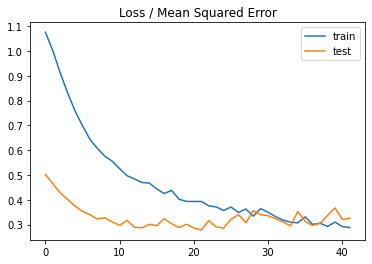

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.title('Loss / Mean Squared Error')
plt.plot(history_t1.history['loss'], label='train')
plt.plot(history_t1.history['val_loss'], label='test')
plt.legend()
#plt.yscale('log')
plt.show()

In [48]:
y_pred = model_t1.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
_, mse_train = model_t1.evaluate(X_train, y_train)
_, mse = model_t1.evaluate(X_test, y_test)
_, mse_all = model_t1.evaluate(X, y_t1)

#_, accuracy = model.evaluate(X, y)
print('MSE (Train): %.2f' % (mse_train))
print('MSE (Test): %.2f' % (mse))
print('MSE (All): %.2f' % (mse_all))

3/3 [==============================] - 0s 1ms/step - loss: 0.3498 - mse: 0.3498
MSE (Train): 0.37
MSE (Test): 0.28
MSE (All): 0.35


In [49]:
print(mse)

0.2788226902484894


In [37]:
y_res = y_test.reset_index()
y_res = y_res['t1_zscore']

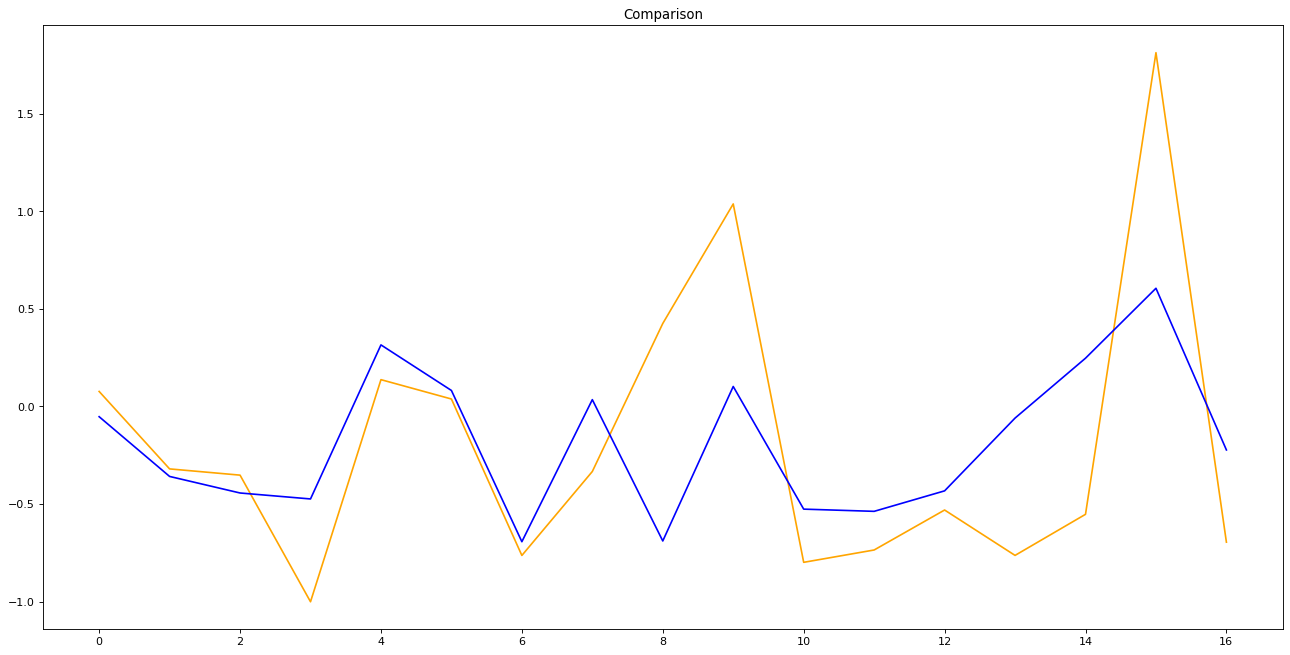

In [38]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Comparison')
plt.plot(y_res, color='orange')
plt.plot(y_pred, color='blue')
plt.show()

In [39]:
idx = y_test.index
ctable = pd.DataFrame(columns=['tier_idol','sub_idol', 'event_type', 'date_start', 'actual_score','predicted_score','difference'])
ctable.head()

Empty DataFrame
Columns: [tier_idol, sub_idol, event_type, date_start, actual_score, predicted_score, difference]
Index: []

In [40]:
c=0
for i in idx:
    ctable.loc[c,'tier_idol'] = df.loc[i, 'ranking_idol']
    ctable.loc[c,'sub_idol'] = df.loc[i, 'appearing_idol_1']
    ctable.loc[c,'event_type'] = df.loc[i, 'event_type']
    ctable.loc[c,'date_start'] = df.loc[i, 'start']
    ctable.loc[c,'actual_score'] = df.loc[i, 't1_cutoff']
    denorm = (y_pred[c][0] * df['t1_cutoff'].std()) + df['t1_cutoff'].mean()
    ctable.loc[c,'predicted_score'] = denorm
    ctable.loc[c,'difference'] = denorm - df.loc[i, 't1_cutoff']
    ctable.loc[c, 'percentage'] =  100-min(denorm,df.loc[i, 't1_cutoff'])/max(denorm,df.loc[i, 't1_cutoff'])*100
    c+=1

In [41]:
ctable

tier_idol           sub_idol event_type date_start actual_score  \
0     hakozaki serika       kasuga mirai    theater     201810       249112   
1     shinomiya karen     nonohara akane       tour     201812       202090   
2       ganaha hibiki       yokoyama nao    theater     201812       198303   
3   tenkubashi tomoka    nikaido chizuru    theater     202003       121427   
4         kousaka umi        miura azusa       tour     202012       256274   
5       satake minako       yokoyama nao       tour     202002       244526   
6      nonohara akane         handa roco    theater     201906       149545   
7      kitakami reika     nonohara akane       tour     202010       200517   
8   tenkubashi tomoka     kitakami reika    theater     201809       290383   
9       tanaka kotoha      tokoro megumi    theater     201804       362962   
10        yabuki kana      ibuki tsubasa    theater     201808       145371   
11   kinoshita hinata    hakozaki serika       tour     201904       152860   
12     kikuchi makoto      maihama ayumu    theater     202003       177130   
13       nakatani iku       nanao yuriko       tour     201803       149580   
14    takatsuki yayoi       amami haruka       tour     202008       174520   
15      emily stewart  shiraishi tsumugi       tour     202001       454786   
16       yokoyama nao   kinoshita hinata    theater     201908       157605   

      predicted_score         difference     percentage  
0   233782.4958598589  -15329.5041401411   6.1536594544  
1   197516.2831074008   -4573.7168925992   2.2632079235  
2   187466.0467947651  -10836.9532052349   5.4648458194  
3   183848.0570110453   62421.0570110453  33.9525247239  
4   277372.0909758136   21098.0909758136   7.6064217209  
5   249707.7631572216    5181.7631572216   2.0751309818  
6   157888.9448442355    8343.9448442355   5.2846922579  
7   244130.3633005254   43613.3633005254  17.8647844991  
8   158341.4961974628 -132041.5038025372  45.4714992966  
9   252124.8172419505 -110837.1827580495  30.5368558577  
10  177665.2801655544   32294.2801655544  18.1770350039  
11  176326.6415210732   23466.6415210732  13.3086193434  
12  188760.7925812561   11630.7925812561   6.1616569957  
13  232946.1475727126   83366.1475727126  35.7877339640  
14  269301.0848125772   94781.0848125772  35.1952109211  
15  311752.1839993228 -143033.8160006772  31.4507957590  
16  213595.3201055806   55990.3201055806  26.2132710014

In [42]:
print("Max Diff: ",ctable.difference.max())
print("Min Diff: ", ctable.difference.min())
print("Avg Diff: ", ctable.difference.apply(abs).mean())
print("Avg % Diff: ", round(ctable.percentage.mean(),2), "%")

Max Diff:  94781.08481257723
Min Diff:  -143033.81600067718
Avg Diff:  50520.00957922556
Avg % Diff:  19.0 %


In [43]:
rk.head()

idol     avg_score
0        futami ami -1.9214164457
1     maihama ayumu -1.5984191976
2       futami mami -1.5487838460
3     fukuda noriko -1.5286677616
4  kinoshita hinata -1.2147259204

In [44]:
df_clean.head(81)

ranking_idol appearing_idol_1 appearing_idol_2 appearing_idol_3  \
0   1.0632513717    -0.9831218882     1.2778319508     0.6158546162   
1   -0.269528052     -0.892331954    -0.3983487268    -1.1090168019   
2   1.7725417519     1.1159193945     2.1751771046     0.1657573181   
3   0.6158546162     1.4726833043     1.0632513717      0.215934015   
4  -0.2216665865    -0.4339780642     0.0892871186      -0.67865045   
..           ...              ...              ...              ...   
78  0.7856785705     -0.187818565     0.9467879669    -0.4028474603   
79  0.5424630683    -0.8315327564    -0.3983487268    -0.2291394716   
80 -0.1308151554    -0.8190878906      -0.67865045    -0.5428511653   
81  -1.548783846     -1.167830486    -1.9214164457    -1.5460102592   
82  1.7725417519     -0.365357231     1.2778319508    -0.1308151554   

   appearing_idol_4 event_type   start      duration  t1_cutoff  t2_cutoff  \
0      -0.187818565    theater  201708  0.8471294754     151347      67477   
1     -0.6673063837    theater  201709  3.2977540294     103398      54179   
2      0.1174481738    theater  201709  3.2977540294     135591      56477   
3      0.9156940091       tour  201710  3.2977540294     371237     137697   
4      -0.365357231    theater  201711  0.8471294754      88037      44374   
..              ...        ...     ...           ...        ...        ...   
78      0.285450128    theater  202002  0.8471294754     336081     102391   
79    -0.1718546037       tour  202002 -0.3781828015     331117      78262   
80     -0.407138374    theater  202003 -0.3781828015     121427      58140   
81    -1.1595076944       tour  202003 -1.6034950785      92580      57195   
82    -0.8315327564    theater  202004  0.8471294754     130822      58741   

    t3_cutoff  event_type_theater  event_type_tour     t1_zscore  \
0       45991                   1                0 -0.7486097191   
1       43411                   1                0 -1.1535131316   
2       41397                   1                0 -0.8816606309   
3       83660                   0                1  1.1082425900   
4       36350                   1                0 -1.2832284816   
..        ...                 ...              ...           ...   
78      59481                   1                0  0.8113691543   
79      53674                   0                1  0.7694508549   
80      48582                   1                0 -1.0012679623   
81      48517                   0                1 -1.2448652999   
82      46625                   1                0 -0.9219322606   

       t2_zscore     t3_zscore  
0  -0.6505999036 -0.8678367427  
1  -1.2160776918 -1.1386643541  
2  -1.1183586395 -1.3500778461  
3   2.3354017728  3.0863513563  
4  -1.6330208197 -1.8798712395  
..           ...           ...  
78  0.8340663244  0.5482347606  
79 -0.1919837247 -0.0613373091  
80 -1.0476420234 -0.5958544399  
81 -1.0878267511 -0.6026776161  
82 -1.0220853870 -0.8012845312  

[81 rows x 16 columns]

In [45]:
pd.set_option("max_rows", 25)